## Track data

In [1]:
import pandas as pd
from helpers.data import (
    create_data_path,
    load_parquet_files_in_dir
)
from helpers.spotify_util import create_spotipy_client
from helpers.util import split_into_chunks_of_size
import os
from tqdm import tqdm
from datetime import date

data_folder = create_data_path("top200_Jan_2017_to_June_2023")
spotify = create_spotipy_client()

In [2]:
track_data_dir =  os.path.join(data_folder, "tracks")
track_df_dict = load_parquet_files_in_dir(track_data_dir)
track_df_dict.keys()

dict_keys(['artists', 'markets', 'original_responses', 'metadata'])

## Metadata

In [3]:
track_metadata = track_df_dict['metadata']
track_metadata.head()

,disc_number,duration_ms,explicit,name,preview_url,track_number,isrc_id,album_id
track_id,,,,,,,,
6mICuAdrwEjh6Y6lroV2Kg,1,195840,False,Chantaje (feat. Maluma),https://p.scdn.co/mp3-preview/1b18b5e5619d1db1...,3,USSD11600299,6bUxh58rYTL67FS8dyTKMN
7DM4BPaS7uofFul3ywMe46,1,259195,False,Vente Pa' Ca (feat. Maluma),https://p.scdn.co/mp3-preview/ecddab17cc70b189...,1,USSD11600252,1FkaJUwfqLdQdSmRPBlw6l
3AEZUABDXNtecAOSC1qTfo,1,222560,False,Reggaetón Lento (Bailemos),https://p.scdn.co/mp3-preview/71b0d8200a5b1f85...,3,USSD11600135,0YLrAWUbY0nyM7PFtqnYld
6rQSrBHf7HlZjtcMZ4S4bO,1,205600,False,Safari,None,3,USUM71604778,2LYwooMTH1iJeBvWyXXWUf
58IL315gMSTD37DOZPJ2hf,1,234320,False,Shaky Shaky,None,1,US2BU1600020,2zrLk90b4qjmrxRZKyIY7X


In [4]:
track_metadata.index.nunique()

163454

In [5]:
assert track_metadata.shape[0] == track_metadata.index.nunique()

In [6]:
track_metadata.isrc_id.isna().sum()

35

The [ISRC](https://en.wikipedia.org/wiki/International_Standard_Recording_Code) is available for almost all tracks! That is convenient, as this _international standardized recoding code_ could be used to obtain further metadata, e.g. from MusicBrainz.

In [7]:
track_metadata.loc['3HoTiqEEY2SmTeq1XGINo3']

disc_number                                                     1
duration_ms                                                185720
explicit                                                    False
name                                                    Si Te Vas
preview_url     https://p.scdn.co/mp3-preview/87d59567192a04b5...
track_number                                                   10
isrc_id                                              ARF101200227
album_id                                   3HZYz8zwaylv9XeIIlLzAX
Name: 3HoTiqEEY2SmTeq1XGINo3, dtype: object

## Markets

In [8]:
track_markets = track_df_dict['markets']
track_markets.head()

,market
track_id,
6mICuAdrwEjh6Y6lroV2Kg,AR
6mICuAdrwEjh6Y6lroV2Kg,AU
6mICuAdrwEjh6Y6lroV2Kg,AT
6mICuAdrwEjh6Y6lroV2Kg,BE
6mICuAdrwEjh6Y6lroV2Kg,BO


In [9]:
track_markets.index.nunique()

122854

In [10]:
track_markets.loc['3HoTiqEEY2SmTeq1XGINo3']

,market
track_id,
3HoTiqEEY2SmTeq1XGINo3,AR
3HoTiqEEY2SmTeq1XGINo3,AU
3HoTiqEEY2SmTeq1XGINo3,AT
3HoTiqEEY2SmTeq1XGINo3,BE
3HoTiqEEY2SmTeq1XGINo3,BO
...,...
3HoTiqEEY2SmTeq1XGINo3,LY
3HoTiqEEY2SmTeq1XGINo3,TJ
3HoTiqEEY2SmTeq1XGINo3,VE


In [11]:
assert track_markets.index.nunique() < track_metadata.shape[0]

In [12]:
track_metadata.shape[0] - track_markets.index.nunique()

40600

That's interesting, market information seems to be missing for quite a few tracks in the dataset?

In [13]:
# get IDs of tracks that are in the metadata but not in the markets
missing_track_ids = track_metadata.index.difference(track_markets.index)
missing_track_ids

Index(['003Tf4XVKCg6tFSv7JKgfz', '003WZkrHUL3u1uAr5ZMJxZ',
       '004nEmGTeP5Mus4qXxz3x2', '004zGvrc84enQHFitC6auy',
       '005oYmIDkyY7FjhNhcfGkv', '006LuHbY5Tt9dhbdSOnVq6',
       '007QSAaELpVxtX5Z6dMn0U', '007S8LPHyug4UrgDWxiCxO',
       '007d7JT41sSc1HqWTs4uw7', '007ogFejDqJKzEXDUDF8Nf',
       ...
       '7zsSUjNwsJ2WUZfLesfkEK', '7ztlf9mCrjoLXAYYf0LCYx',
       '7zuxN6mJ6Wc27TXfQ6GPZL', '7zvfDihYiJ8RQ1nRcpKBF5',
       '7zwO9KmNWzxKJj3wBdUXL5', '7zxd3J5hMPeLN71VS8vnE4',
       '7zyWKLsmcHObOAXoBaOo5o', '7zzI3SbctTJN6wDerZNZCD',
       '7zzbnhCpuuHOCrhBGvgwpp', '7zzhRAobAnNjarw2FAWt65'],
      dtype='object', name='track_id', length=40600)

Does the Spotify API really not return any market data for those tracks?

To verify that, we need to understand how to obtain the market information from each API response (using `spotipy`, which is the wrapper for the Spotify API that was also used for getting the data initially):

In [14]:
example_track_markets = spotify.track(missing_track_ids[0])['available_markets']
example_track_markets

[]

We see that for the example, the response is indeed empty. We can write an assertion to test that for other cases. It will throw an `AssertionError` if it is not fulfilled.

In [15]:
def check_for_no_available_markets(api_track_response, track_id):
    assert api_track_response["available_markets"] == [], f"available_markets is not empty for track_id: {track_id}"

In [16]:
# demo: check for single track
check_for_no_available_markets(spotify.track(missing_track_ids[0]), missing_track_ids[0])

In [17]:
# demo: check for multiple tracks at once
for api_response, track_id in zip(spotify.tracks(missing_track_ids[:2])["tracks"], missing_track_ids[:2]):
    check_for_no_available_markets(api_response, track_id)

Let's test this for all the IDs we have obtained. If a few IDs happen to be available, we will not change anything about our dataset (the data in the Spotify API changes all the time anyway).

In [18]:
# check for all (commented out to avoid spamming Spotify API with 40k tracks every time this notebook is run)
track_id_chunks = split_into_chunks_of_size(missing_track_ids, 50) # max. 50 tracks per request

# ids_with_available_markets = []
# for track_ids in tqdm(track_id_chunks):
#     for api_response, track_id in zip(spotify.tracks(track_ids)["tracks"], track_ids):
#         try:
#             check_for_no_available_markets(api_response, track_id)
#         except AssertionError:
#             ids_with_available_markets.append(track_id)

# len(ids_with_available_markets)

To save us from getting blocked by the Spotify API (making requests with over 40k tracks repeatedly is probably a bit problematic), I have commented out the code cell above. However, the output when I ran this on 16th of July 2023 was:

![Output of unavailable track markets check](./images/screenshot-track-markets-check.jpg)

I.e., only for 4 IDs where our collected market data is empty, the available markets API response was non-empty. It's absolutely NOT worth recreating the dataset for 4 IDs lol

But still, it would be interesting to know why such a substantial portion of tracks (roughly 40k out of the total 160k) is apparently currently not available anywhere 🤔

My hypothesis is that many tracks are just re-released later and the old version is taken down from Spotify. We could verify this by collecting track IDs that are associated with the same physical recording, identified via the ISRC.

In [19]:
# TODO: check hypothesis outlined from above

In [20]:
track_markets.market.value_counts()

NO    117418
FI    117314
DK    117273
CW    117223
DE    117094
       ...  
LY    114700
CD    114682
BF    114676
BN    114660
BY    104249
Name: market, Length: 184, dtype: int64

## Artists

In [21]:
track_artists = track_df_dict['artists']
track_artists.head()

,artist_id,pos
track_id,,
6mICuAdrwEjh6Y6lroV2Kg,0EmeFodog0BfCgMzAIvKQp,1
6mICuAdrwEjh6Y6lroV2Kg,1r4hJ1h58CWwUQe3MxPuau,2
7DM4BPaS7uofFul3ywMe46,7slfeZO9LsJbWgpkIoXBUJ,1
7DM4BPaS7uofFul3ywMe46,1r4hJ1h58CWwUQe3MxPuau,2
3AEZUABDXNtecAOSC1qTfo,0eecdvMrqBftK0M1VKhaF4,1


In [22]:
assert track_artists.index.nunique() == track_metadata.shape[0] # an artist entry should exist in our collected data for every track

<Axes: title={'center': 'Number of participating artists in tracks in the top 200'}>

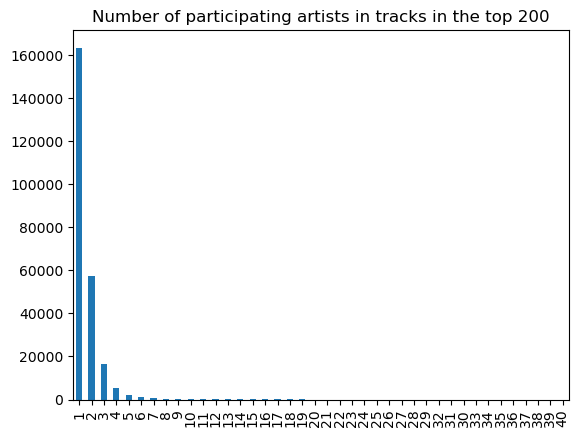

In [23]:
track_artists.pos.value_counts().plot(kind='bar', title='Number of participating artists in tracks in the top 200')

The vast majority of chart hits are performed by a single artist.

## Original Responses

In [24]:
original_responses = track_df_dict['original_responses']
original_responses.head()

,source,content,timestamp
0,"Spotify API (spotipy v2.23.0, client method: '...","[{'album_id': '6bUxh58rYTL67FS8dyTKMN', 'disc_...",2023-08-01 20:36:47.746907
1,"Spotify API (spotipy v2.23.0, client method: '...","[{'album_id': '7K89F9bgY1jks0uIlMerm3', 'disc_...",2023-08-01 20:36:48.032282
2,"Spotify API (spotipy v2.23.0, client method: '...","[{'album_id': '2kZkiVn1m00XcgaWlLb2LD', 'disc_...",2023-08-01 20:36:48.315727
3,"Spotify API (spotipy v2.23.0, client method: '...","[{'album_id': '0zXEyFkwoxht6Bqd3SgnOm', 'disc_...",2023-08-01 20:36:48.647495
4,"Spotify API (spotipy v2.23.0, client method: '...","[{'album_id': '4blCxKnK1sGo9D45trrqjt', 'disc_...",2023-08-01 20:36:48.946816


In [25]:
original_responses.timestamp.min(), original_responses.timestamp.max()

(Timestamp('2023-08-01 20:36:47.746907'),
 Timestamp('2023-08-01 20:48:00.155949'))